# --Index--
## 1. Setup
## 2. Model
## 3. Data Process
## 4. Results
```
   4-1 gel
   4-2 cap
   4-3 gel+att
   4-4 cap+att
   4-5 gel+cap+att
   +(CM, ROC, AUC)
```

# 1 Setup

In [1]:
import datetime, cv2, csv, os, glob, locale
from pprint import pprint

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

# 텐서보드 활성화
%load_ext tensorboard

# 2 Model

In [2]:
def create_mlp(dim, regress=False):
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))

	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))

	return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	# apply another FC layer, this one to match the number of nodes coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)

	model = Model(inputs, x)

	return model

In [3]:
def draw_CM(label, predicted):
    cm = confusion_matrix(label, predicted)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # true : false rate
    true = 0
    false = 0
    for i, j in enumerate(label):
        if j != predicted[i] :
            false += 1
        else: true += 1

    classification_report = metrics.classification_report(label, predicted)

    multilabel_to_binary_matrics = metrics.multilabel_confusion_matrix(label, predicted)

    return plt.show(), print('true rate: ', true), print('false rate: ', false), print(), print('='*10, 'classification_report: ', '\n', classification_report), print('='*10, 'multilabel_to_binary_matrics by class_num: ','\n','[[TN / FP] [FN / TP]]','\n', multilabel_to_binary_matrics)

In [4]:
def draw_ROC_AUC(x, y, category_names):
    n_classes = len(category_names)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], x[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), x.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})', 
            color='deeppink', linestyle=':', linewidth=1)

    plt.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy', linestyle=':', linewidth=1)

    colors = (['purple', 'pink', 'red', 'green', 'yellow', 'cyan', 'magenta', 'blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC')
    plt.legend(loc="lower right")

    return plt.show()

# 3 Data Preprocessing

파일 이름안에 정보가 다 들어 있다.

예를 들어 SEP_APR/090122113_180113_81_6.2_3.5_0_ca.png 파일의 경우
```
SEP_APR/090122113_180113_81_6.2_3.5_0_ca.png
    APR : Dx_1. 분류하려는 카테고리이름
               81 :Age    6.2 :Protein_serum    3.5 :Albumin    0 :Previous_Dx
```

In [5]:
########## Make DataFrame ##########
DATA_PATH = '201027_EPAI_tot_modi'
file_path = os.path.join(DATA_PATH)
category_names = os.listdir(DATA_PATH)
classes = list(range(len(category_names)))

data = []
gel_files=[]
cap_files=[]

for i in glob.glob(file_path + "**/**/*.png", recursive=True):
    dirname = os.path.dirname(i)
    dir_basename = os.path.basename(dirname)
    for num, name in enumerate(category_names):
        if dir_basename == name:
            y = num

    basename = os.path.basename(i)
    basename = basename.replace('.png', '')
    info = basename.split("_")

    if len(info) < 6:
        continue
    if 'ca' in info[5]:
        continue

    att = info[2], info[3], info[4], info[5]
    att = list(map(float, att))

    img = 'cap' if len(info) == 6 else 'gel'

    if len(data) < 3:
        data.append([i, y, att, img])
    else:
        if data[-1][3] == img:
            data.pop()
            data.append([i, y, att, img])
        else:
            data.append([i, y, att, img])

for i, j in enumerate(data):
    gel_files.append(j) if data[i][3] == 'gel' else cap_files.append(j)

df = pd.DataFrame(data, columns=['path', 'y', 'att', 'img'])
df

df.to_csv('data.csv')

In [6]:
# 이미지
gel = []
gel1 = []
cap = []
# 속성
att = []
# 카테고리 index
y = []

GEL_WIDTH = 256
GEL_HEIGHT = 160
CAP_WIDTH = 128
CAP_HEIGHT = 32

for gel_file in gel_files:
    gel_img = cv2.imread(gel_file[0], cv2.IMREAD_GRAYSCALE)
    gel_resize = cv2.resize(gel_img, dsize=(GEL_WIDTH, GEL_HEIGHT), interpolation=cv2.INTER_AREA)
    gel.append(gel_resize)

    gel_resize1 = cv2.resize(gel_img, dsize=(CAP_WIDTH, CAP_HEIGHT), interpolation=cv2.INTER_AREA)
    gel1.append(gel_resize1)

    att.append(gel_file[2])
    y.append(gel_file[1])

for cap_file in cap_files:
    cap_img = cv2.imread(cap_file[0], cv2.IMREAD_GRAYSCALE)
    cap_resize = cv2.resize(cap_img, dsize=(CAP_WIDTH, CAP_HEIGHT), interpolation=cv2.INTER_AREA)
    cap.append(cap_resize)

gel = np.array(gel)
gel = gel / 255.0
gel1 = np.array(gel1)
gel1 = gel1 / 255.0
cap = np.array(cap)
cap = cap / 255.0
att = np.array(att)
y = np.array(y)

print("gel.shape :", gel.shape)
print("cap.shape :", cap.shape)
print("attr.shape :", att.shape)
print("y.shape :", y.shape)
print("gel1.shape :", gel1.shape)

gel.shape : (400, 160, 256)
gel1.shape : (400, 32, 128)
cap.shape : (400, 32, 128)
attr.shape : (400, 4)
y.shape : (400,)


## Standardize -> Shuffle -> Split

In [7]:
# att Standardize
for i in range(len(att[0])):
  target_column = att[:,i]
  mean = np.mean(target_column)
  centered = target_column - mean
  norms = np.linalg.norm(centered)
  normed = centered / norms
  att[:,i] = normed.T

# Shuffle
# shuffled_index = np.random.RandomState(seed=1).permutation(len(gel))
shuffled_index = np.random.permutation(len(gel))
gel = gel[shuffled_index]
cap = cap[shuffled_index]
att = att[shuffled_index]
y = y[shuffled_index]
gel1 = gel1[shuffled_index]

# Split
split_index = int(len(gel)*0.8)
train_gel, test_gel = gel[:split_index], gel[split_index:]
train_cap, test_cap = cap[:split_index], cap[split_index:]
train_att, test_att = att[:split_index], att[split_index:]
train_y, test_y = y[:split_index], y[split_index:]
train_gel1, test_gel1 = gel1[:split_index], gel1[split_index:]

# make instances of the CNN
mlp = create_mlp(train_att.shape[1], regress=False)
gel_cnn = create_cnn(GEL_WIDTH, GEL_HEIGHT, 1, regress=False)
cap_cnn = create_cnn(CAP_WIDTH, CAP_HEIGHT, 1, regress=False)
gel1_cnn = create_cnn(CAP_WIDTH, CAP_HEIGHT, 1, regress=False)

## data 분포

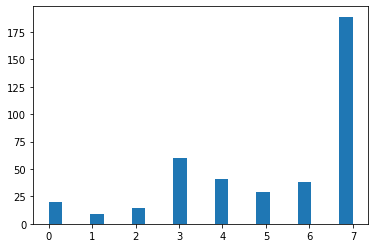

In [8]:
plt.hist(y, bins=22)
plt.show()

# 4 Result
1. gel 이미지
2. cap 이미지
3. gel 이미지 + 속성
4. cap 이미지 + 속성
5. gel 이미지 + cap 이미지 + 속성

include CM, ROC, AUC for all

## 1 GEL

In [9]:
########## Train ##########
log_dir_1 = "logs/fit/1_gel_" + datetime.datetime.now().strftime("%m%d_%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_1, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

gel_input = gel_cnn.outp
x = Dense(4, activation="relu")(gel_input)
output = Dense(8, activation="softmax")(x)

model_1 = Model(inputs=gel_cnn.input, outputs=output)

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['acc'])

Epoch 1/16
72/72 [==============================] - 9s 48ms/step - loss: 2.1987 - acc: 0.1525 - val_loss: 2.1614 - val_acc: 0.1875
Epoch 2/16
72/72 [==============================] - 1s 16ms/step - loss: 2.0606 - acc: 0.3349 - val_loss: 2.0367 - val_acc: 0.1875
Epoch 3/16
72/72 [==============================] - 1s 16ms/step - loss: 1.9947 - acc: 0.4362 - val_loss: 1.9618 - val_acc: 0.1875
Epoch 4/16
72/72 [==============================] - 1s 16ms/step - loss: 1.9570 - acc: 0.4506 - val_loss: 1.9092 - val_acc: 0.1875
Epoch 5/16
72/72 [==============================] - 1s 17ms/step - loss: 1.9021 - acc: 0.4569 - val_loss: 1.8335 - val_acc: 0.1875
Epoch 6/16
72/72 [==============================] - 1s 16ms/step - loss: 1.8692 - acc: 0.5013 - val_loss: 1.7770 - val_acc: 0.2500
Epoch 7/16
72/72 [==============================] - 1s 16ms/step - loss: 1.8085 - acc: 0.5109 - val_loss: 1.7128 - val_acc: 0.5625
Epoch 8/16
72/72 [==============================] - 1s 16ms/step - loss: 1.8202 - a

In [ ]:
model_1.fit(train_gel, train_y, validation_split=0.1, epochs=16, batch_size=4, callbacks=[tensorboard_callback, es])

In [10]:
########## Evaluate ##########
model_1.evaluate(test_gel, test_y)

3/3 [==============================] - 1s 107ms/step - loss: 2.7666 - acc: 0.0500


[2.7665886878967285, 0.05000000074505806]

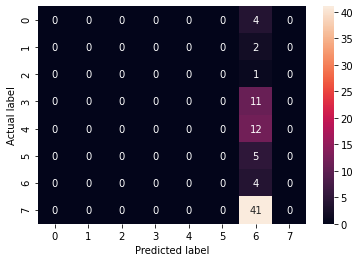

true rate:  4
false rate:  76

========== classification_report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         5
           6       0.05      1.00      0.10         4
           7       0.00      0.00      0.00        41

    accuracy                           0.05        80
   macro avg       0.01      0.12      0.01        80
weighted avg       0.00      0.05      0.00        80

========== multilabel_to_binary_matrics by class_num:  
 [[[76  0]
  [ 4  0]]

 [[78  0]
  [ 2  0]]

 [[79  0]
  [ 1  0]]

 [[69  0]
  [11  0]]

 [[68  0]
  [12  0]]

 [[75  0]
  [ 5  0]]

 [[ 0 76]
  [ 0  4]]

 [[39  0]
  [41  0]]]


(None, None, None, None, None, None)

In [11]:
########## CM ##########
y1 = model_1.predict(test_gel)
predicted1 = np.argmax(y1, axis=1)

draw_CM(test_y, predicted1)

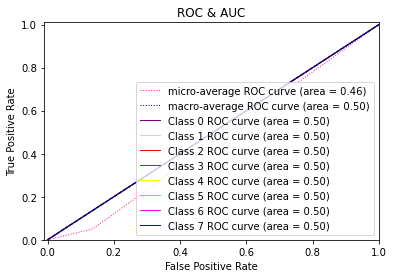

In [12]:
########## ROC, AUC ##########
y1 = label_binarize(test_y, classes=classes)
x1 = label_binarize(predicted1, classes=classes)

draw_ROC_AUC(x1, y1, category_names)

## 2 CAP

In [13]:
########## Train ##########
log_dir_2 = "logs/fit/2_CAP_" + datetime.datetime.now().strftime("%m%d_%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_2, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

cap_input = cap_cnn.output
x = Dense(4, activation="relu")(cap_input)
output = Dense(8, activation="softmax")(x)

model_2 = Model(inputs=cap_cnn.input, outputs=output)

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model_2.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['acc'])

model_2.fit(train_cap, train_y, validation_split=0.1, epochs=16, batch_size=4, callbacks=[tensorboard_callback, es])

Epoch 1/16
72/72 [==============================] - 5s 49ms/step - loss: 2.1301 - acc: 0.1389 - val_loss: 2.0376 - val_acc: 0.4062
Epoch 2/16
72/72 [==============================] - 1s 10ms/step - loss: 2.0153 - acc: 0.3419 - val_loss: 2.0006 - val_acc: 0.4062
Epoch 3/16
72/72 [==============================] - 1s 10ms/step - loss: 1.9673 - acc: 0.4512 - val_loss: 2.0579 - val_acc: 0.4375
Epoch 4/16
72/72 [==============================] - 1s 10ms/step - loss: 1.9245 - acc: 0.4579 - val_loss: 1.9313 - val_acc: 0.4062
Epoch 5/16
72/72 [==============================] - 1s 10ms/step - loss: 1.8250 - acc: 0.4609 - val_loss: 1.8817 - val_acc: 0.4375
Epoch 6/16
72/72 [==============================] - 1s 11ms/step - loss: 1.7966 - acc: 0.4863 - val_loss: 1.9741 - val_acc: 0.2188
Epoch 7/16
72/72 [==============================] - 1s 10ms/step - loss: 1.8611 - acc: 0.4450 - val_loss: 1.8131 - val_acc: 0.4062
Epoch 8/16
72/72 [==============================] - 1s 10ms/step - loss: 1.7027 - a

In [14]:
########## Evaluate ##########
model_2.evaluate(test_cap, test_y)

3/3 [==============================] - 1s 50ms/step - loss: 2.0397 - acc: 0.5125


[2.0396921634674072, 0.512499988079071]

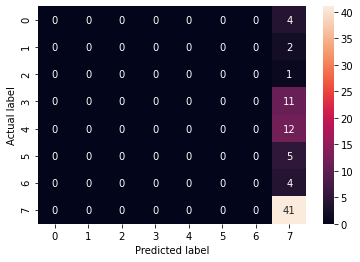

true rate:  41
false rate:  39

========== classification_report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         4
           7       0.51      1.00      0.68        41

    accuracy                           0.51        80
   macro avg       0.06      0.12      0.08        80
weighted avg       0.26      0.51      0.35        80

========== multilabel_to_binary_matrics by class_num:  
 [[[76  0]
  [ 4  0]]

 [[78  0]
  [ 2  0]]

 [[79  0]
  [ 1  0]]

 [[69  0]
  [11  0]]

 [[68  0]
  [12  0]]

 [[75  0]
  [ 5  0]]

 [[76  0]
  [ 4  0]]

 [[ 0 39]
  [ 0 41]]]


(None, None, None, None, None, None)

In [15]:
########## CM ##########
y2 = model_2.predict(test_cap)
predicted2 = np.argmax(y2, axis=1)

draw_CM(test_y, predicted2)

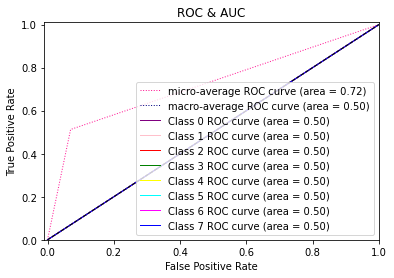

In [16]:
########## ROC, AUC ##########
y2 = label_binarize(test_y, classes=classes)
x2 = label_binarize(predicted2, classes=classes)

draw_ROC_AUC(x2, y2, category_names)

## 3 GEL + Attributes

In [17]:
log_dir_3 = "logs/fit/3_GEL+Att_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_3, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

Input_3 = concatenate([mlp.output, gel_cnn.output])
x = Dense(4, activation="relu")(Input_3)
output = Dense(len(category_names), activation="softmax")(x)

model_3 = Model(inputs=[mlp.input, gel_cnn.input], outputs=output)
optimizer = Adam(lr=1e-3, decay=1e-3 / 200)
model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['acc'])

model_3.fit([train_att, train_gel], train_y, validation_split=0.1, epochs=16, batch_size=4, callbacks=[tensorboard_callback, es])

Epoch 1/16
72/72 [==============================] - 6s 59ms/step - loss: 2.0554 - acc: 0.4363 - val_loss: 20.7261 - val_acc: 0.4062
Epoch 2/16
72/72 [==============================] - 1s 17ms/step - loss: 1.9936 - acc: 0.4783 - val_loss: 7.2643 - val_acc: 0.4062
Epoch 3/16
72/72 [==============================] - 1s 17ms/step - loss: 1.8957 - acc: 0.4294 - val_loss: 65.1828 - val_acc: 0.4688
Epoch 4/16
72/72 [==============================] - 1s 17ms/step - loss: 1.7465 - acc: 0.4684 - val_loss: 76.8521 - val_acc: 0.2500
Epoch 5/16
72/72 [==============================] - 1s 18ms/step - loss: 1.6028 - acc: 0.5044 - val_loss: 65.1925 - val_acc: 0.4062
Epoch 6/16
72/72 [==============================] - 1s 17ms/step - loss: 1.5679 - acc: 0.4425 - val_loss: 2.6290 - val_acc: 0.4062
Epoch 7/16
72/72 [==============================] - 1s 17ms/step - loss: 1.5042 - acc: 0.4727 - val_loss: 1.6707 - val_acc: 0.4062
Epoch 8/16
72/72 [==============================] - 1s 17ms/step - loss: 1.5644

In [18]:
########## 평가 ##########
model_3.evaluate([test_att, test_gel], test_y)

3/3 [==============================] - 0s 19ms/step - loss: 49.5086 - acc: 0.4875


[49.50856399536133, 0.48750001192092896]

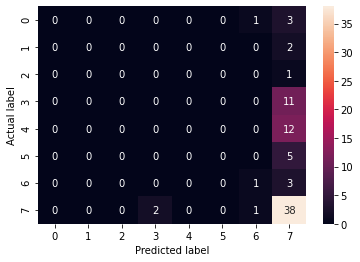

true rate:  39
false rate:  41

========== classification_report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         5
           6       0.33      0.25      0.29         4
           7       0.51      0.93      0.66        41

    accuracy                           0.49        80
   macro avg       0.11      0.15      0.12        80
weighted avg       0.28      0.49      0.35        80

========== multilabel_to_binary_matrics by class_num:  
 [[[76  0]
  [ 4  0]]

 [[78  0]
  [ 2  0]]

 [[79  0]
  [ 1  0]]

 [[67  2]
  [11  0]]

 [[68  0]
  [12  0]]

 [[75  0]
  [ 5  0]]

 [[74  2]
  [ 3  1]]

 [[ 2 37]
  [ 3 38]]]


(None, None, None, None, None, None)

In [19]:
########## CM ##########
y3 = model_3.predict([test_att, test_gel])
predicted3 = np.argmax(y3, axis=1)

draw_CM(test_y, predicted3)

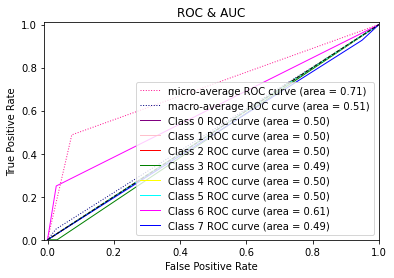

In [20]:
########## ROC, AUC ##########
y3 = label_binarize(test_y, classes=classes)
x3= label_binarize(predicted3, classes=classes)

draw_ROC_AUC(x3, y3, category_names)

## 4 CAP + Attributes

In [21]:
log_dir_4 = "logs/fit/4_CAP+Att_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_4, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

Input_4 = concatenate([mlp.output, cap_cnn.output])
x = Dense(4, activation="relu")(Input_4)
output = Dense(len(category_names), activation="softmax")(x)

model_4 = Model(inputs=[mlp.input, cap_cnn.input], outputs=output)
optimizer = Adam(lr=1e-3, decay=1e-3 / 200)
model_4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['acc'])

In [22]:
model_4.fit([train_att, train_cap], train_y, validation_split=0.1, epochs=16, batch_size=4, callbacks=[tensorboard_callback, es])

Epoch 1/16
72/72 [==============================] - 5s 56ms/step - loss: 2.2428 - acc: 0.1167 - val_loss: 2.1259 - val_acc: 0.0625
Epoch 2/16
72/72 [==============================] - 1s 12ms/step - loss: 2.0217 - acc: 0.1702 - val_loss: 3.6095 - val_acc: 0.0000e+00
Epoch 3/16
72/72 [==============================] - 1s 11ms/step - loss: 1.8585 - acc: 0.4206 - val_loss: 1.9851 - val_acc: 0.3438
Epoch 4/16
72/72 [==============================] - 1s 11ms/step - loss: 1.7334 - acc: 0.4559 - val_loss: 1.9563 - val_acc: 0.4062
Epoch 5/16
72/72 [==============================] - 1s 12ms/step - loss: 1.6474 - acc: 0.4692 - val_loss: 2.0767 - val_acc: 0.4062
Epoch 6/16
72/72 [==============================] - 1s 12ms/step - loss: 1.5671 - acc: 0.4837 - val_loss: 1.5276 - val_acc: 0.4062
Epoch 7/16
72/72 [==============================] - 1s 11ms/step - loss: 1.5258 - acc: 0.4815 - val_loss: 1.4197 - val_acc: 0.4062
Epoch 8/16
72/72 [==============================] - 1s 11ms/step - loss: 1.4970

In [23]:
########## 평가 ##########
model_4.evaluate([test_att, test_cap], test_y)

3/3 [==============================] - 0s 8ms/step - loss: 1.7050 - acc: 0.5375


[1.7049554586410522, 0.5375000238418579]

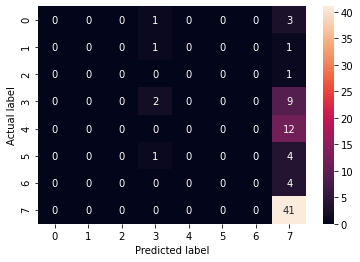

true rate:  43
false rate:  37

========== classification_report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.40      0.18      0.25        11
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         4
           7       0.55      1.00      0.71        41

    accuracy                           0.54        80
   macro avg       0.12      0.15      0.12        80
weighted avg       0.34      0.54      0.40        80

========== multilabel_to_binary_matrics by class_num:  
 [[[76  0]
  [ 4  0]]

 [[78  0]
  [ 2  0]]

 [[79  0]
  [ 1  0]]

 [[66  3]
  [ 9  2]]

 [[68  0]
  [12  0]]

 [[75  0]
  [ 5  0]]

 [[76  0]
  [ 4  0]]

 [[ 5 34]
  [ 0 41]]]


(None, None, None, None, None, None)

In [24]:
########## CM ##########
y4 = model_4.predict([test_att, test_cap])
predicted4 = np.argmax(y4, axis=1)

draw_CM(test_y, predicted4)

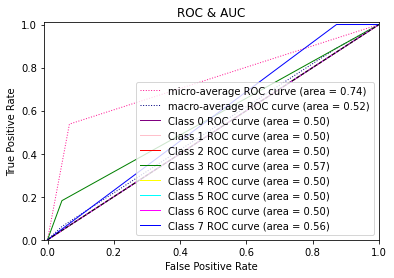

In [25]:
########## ROC, AUC ##########
y4 = label_binarize(test_y, classes=classes)
x4 = label_binarize(predicted4, classes=classes)

draw_ROC_AUC(x4, y4, category_names)

## 5 GEL + CAP + Att

In [26]:
log_dir_5 = "logs/fit/5_GEL+CAP+Att_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_5, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

Input_5 = concatenate([model_4.output, gel1_cnn.output])
x = Dense(4, activation="relu")(Input_5)
output = Dense(len(category_names), activation="softmax")(x)

model_5 = Model(inputs=[model_4.input, gel1_cnn.input], outputs=output)
optimizer = Adam(lr=1e-3, decay=1e-3 / 200)
model_5.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['acc'])

model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 128, 16)  160         input_2[0][0]                    
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 32, 128, 16)  0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 32, 128, 16)  64          activation_5[0][0]               
____________________________________________________________________________________________

In [27]:
model_5.fit([train_att, train_cap, train_gel1], train_y, validation_split=0.1, epochs=16, batch_size=4, callbacks=[tensorboard_callback, es])

Epoch 1/16
72/72 [==============================] - 8s 76ms/step - loss: 1.9862 - acc: 0.3614 - val_loss: 2.0497 - val_acc: 0.0000e+00
Epoch 2/16
72/72 [==============================] - 1s 17ms/step - loss: 1.7976 - acc: 0.4868 - val_loss: 1.9535 - val_acc: 0.4062
Epoch 3/16
72/72 [==============================] - 1s 17ms/step - loss: 1.7377 - acc: 0.4526 - val_loss: 1.8902 - val_acc: 0.4062
Epoch 4/16
72/72 [==============================] - 1s 17ms/step - loss: 1.6461 - acc: 0.4770 - val_loss: 1.7922 - val_acc: 0.4062
Epoch 5/16
72/72 [==============================] - 1s 19ms/step - loss: 1.5665 - acc: 0.4645 - val_loss: 1.7104 - val_acc: 0.4062
Epoch 6/16
72/72 [==============================] - 1s 18ms/step - loss: 1.4935 - acc: 0.4859 - val_loss: 1.6865 - val_acc: 0.4062
Epoch 7/16
72/72 [==============================] - 1s 18ms/step - loss: 1.5363 - acc: 0.4622 - val_loss: 1.6745 - val_acc: 0.4062
Epoch 8/16
72/72 [==============================] - 2s 21ms/step - loss: 1.5061

In [28]:
########## 평가 ##########
model_5.evaluate([test_att, test_cap, test_gel1], test_y)

3/3 [==============================] - 1s 10ms/step - loss: 1.3140 - acc: 0.5375


[1.313968300819397, 0.5375000238418579]

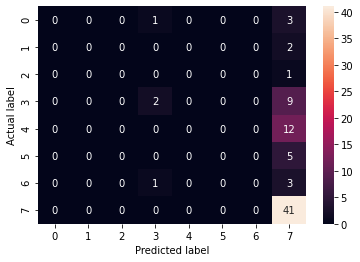

true rate:  43
false rate:  37

========== classification_report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.50      0.18      0.27        11
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         4
           7       0.54      1.00      0.70        41

    accuracy                           0.54        80
   macro avg       0.13      0.15      0.12        80
weighted avg       0.35      0.54      0.40        80

========== multilabel_to_binary_matrics by class_num:  
 [[[76  0]
  [ 4  0]]

 [[78  0]
  [ 2  0]]

 [[79  0]
  [ 1  0]]

 [[67  2]
  [ 9  2]]

 [[68  0]
  [12  0]]

 [[75  0]
  [ 5  0]]

 [[76  0]
  [ 4  0]]

 [[ 4 35]
  [ 0 41]]]


(None, None, None, None, None, None)

In [29]:
########## CM ##########
y5 = model_5.predict([test_att, test_cap, test_gel1])
predicted5 = np.argmax(y5, axis=1)

draw_CM(test_y, predicted5)

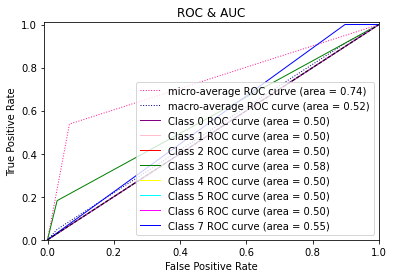

In [30]:
########## ROC, AUC ##########
y5 = label_binarize(test_y, classes=classes)
x5 = label_binarize(predicted5, classes=classes)

draw_ROC_AUC(x5, y5, category_names)

# 마무리

In [31]:
########## localhost:6006 에서 tensorboad 접속 ##########
%tensorboard --logdir logs/fit --host localhost --port 6006

Reusing TensorBoard on port 6006 (pid 24988), started 1 day, 3:47:25 ago. (Use '!kill 24988' to kill it.)

## 결론
7번 category 제외하고는 데이터 갯수가 부족해 학습이 안된다

model copied from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/